# Demonstration of gear diagnosis

In [1]:
import numpy as np
import scipy.io
from scipy.interpolate import interp1d, UnivariateSpline
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

In [2]:
# Load data
mat_contents = scipy.io.loadmat('D:\data\work_with_Eric\Signal processing for CBM - a tutorial\demo_gear_diagnosis.mat')
dt = mat_contents['dt'][0][0]
sigs_faulty_t = np.array(mat_contents['sigs_faulty_t'].squeeze())
sigs_healthy_t = np.array(mat_contents['sigs_healthy_t'].squeeze())
speed_faulty = np.array(mat_contents['speed_faulty'].squeeze())
speed_healthy = np.array(mat_contents['speed_healthy'].squeeze())

In [3]:
def angular_resampling(t, speed, sig_t):
    # Time resolution
    dt = t[1] - t[0]
    
    # Calculate cumulative phase of the shaft
    cumulative_phase = np.cumsum(speed * dt)
    cumulative_phase -= cumulative_phase[0]

    # Sampling rate in the cycle domain after angular resampling
    cyc_fs = int(1 / (dt * min(speed)))
    
    # Generate constant phase intervals
    constant_phase_intervals = np.linspace(0, max(cumulative_phase), int(cyc_fs * max(cumulative_phase)))
    
    # Interpolate to find new time points with constant phase intervals
    interp_func = interp1d(cumulative_phase, t, kind='linear')
    times_of_constant_phase_intervals = interp_func(constant_phase_intervals)
    
    # Use UnivariateSpline for spline interpolation
    spline_interpolator = UnivariateSpline(t, sig_t, s=0)  # s=0 means no smoothing
    sig_cyc = spline_interpolator(times_of_constant_phase_intervals)

    # Sample points for optional resampling back to the time domain
    sample_pnts = {
        'times_of_constant_time_intervals': t,
        'times_of_constant_phase_intervals': times_of_constant_phase_intervals
    }

    return sig_cyc, cyc_fs, sample_pnts


def calc_sa(sig_cyc, sa_len):
    # Calculate the synchronous average.
    
    num_sgmnts = len(sig_cyc) // sa_len
    sig_cyc = sig_cyc[:num_sgmnts * sa_len]
    sigs_mtrx = np.reshape(sig_cyc, (sa_len, num_sgmnts), order='F')  # MATLAB uses Fortran-style column-major order

    sa = np.mean(sigs_mtrx, axis=1)

    return sa


def calc_difference_signal(sa, gear_mesh, num_sidebands):
    # Synchronous average length
    sa_len = len(sa)
    
    # Maximum order
    max_order = sa_len // 2
    
    # Find the order values to remove
    orders_2_remove = []
    num_of_gear_mesh_harmonics = max_order // gear_mesh
    for ii in range(1, num_of_gear_mesh_harmonics + 1):
        gear_mesh_harmonic_order = gear_mesh * ii
        orders_2_remove += list(range(gear_mesh_harmonic_order - num_sidebands, gear_mesh_harmonic_order + num_sidebands + 1))

    # Remove orders that exceed the maximum order
    orders_2_remove = [order for order in orders_2_remove if order <= max_order]
    orders_2_remove_positive_inds = np.array(orders_2_remove) + 1
    orders_2_remove_negative_inds = sa_len - orders_2_remove_positive_inds + 2
    orders_2_remove_inds = np.sort(np.concatenate([orders_2_remove_positive_inds, orders_2_remove_negative_inds]))

    # Convert from cycle to order
    sa_order = fft(sa, sa_len)

    # Set orders to remove to zero
    sa_order[orders_2_remove_inds] = 0

    # Convert from order to cycle
    difference_sig = np.real(ifft(sa_order, sa_len))

    return difference_sig


def dephase(t, speed, sig_t, num_of_fllwing_sgmnts_2_average):
    # angular resampling
    sig_cyc, cyc_fs, sample_pnts = angular_resampling(t, speed, sig_t)

    sa_len = cyc_fs  # number of points in the synchronous average
    sgmnt_len = sa_len * num_of_fllwing_sgmnts_2_average  # length of the averaged segment
    sig_cyc_after_dephase = np.zeros_like(sig_cyc)
    
    for long_sgmnt_num in range(1, int(np.ceil(len(sig_cyc) / sgmnt_len)) + 1):
        # separation to segments
        first_ind = (long_sgmnt_num - 1) * sgmnt_len
        last_ind = long_sgmnt_num * sgmnt_len
        
        if last_ind > len(sig_cyc):
            last_ind = len(sig_cyc)
            first_ind = len(sig_cyc) - sgmnt_len
        
        sgmnt = sig_cyc[first_ind:last_ind]
        
        # synchronous average
        sa = calc_sa(sgmnt, sa_len)

        # concatenation
        concatenated_sa = np.tile(sa, (num_of_fllwing_sgmnts_2_average))

        # subtraction
        subtracted_sgmnt = sig_cyc[first_ind:last_ind] - concatenated_sa

        # assembly of the segments
        sig_cyc_after_dephase[first_ind:last_ind] = subtracted_sgmnt

    # Convert back from the cycle domain to the time domain
    spline_interpolator = UnivariateSpline(sample_pnts['times_of_constant_phase_intervals'], sig_cyc_after_dephase, s=0)  # s=0 means no smoothing
    sig_t_after_dephase = spline_interpolator(sample_pnts['times_of_constant_time_intervals'])

    return sig_t_after_dephase

In [4]:
# Processing of the healthy signals
num_healthy_sigs = sigs_healthy_t.shape[1]
healthy_features = np.zeros((4, num_healthy_sigs))
for sig_num in range(num_healthy_sigs):
    sig_healthy = sigs_healthy_t[:, sig_num]
    speed_faulty_t = speed_healthy[:, sig_num]
    t = np.arange(0, len(sig_healthy) * dt, dt)

    # angular resampling
    sig_cyc, cyc_fs, sample_pnts = angular_resampling(t, speed_faulty_t, sig_healthy)
    num_pnts_in_round = cyc_fs

    # synchronous average
    sa = calc_sa(sig_cyc, num_pnts_in_round)

    # difference signal
    gear_mesh = 38
    num_sidebands = 2
    difference_sig = calc_difference_signal(sa, gear_mesh, num_sidebands)  # Assuming 'gear_mesh' and 'num_sidebands' are constants

    # features extraction
    sa_rms = np.sqrt(np.mean(sa**2))
    sa_kurtosis = np.mean((sa - np.mean(sa))**4) / (np.mean((sa - np.mean(sa))**2)**2)
    difference_rms = np.sqrt(np.mean(difference_sig**2))
    difference_skewness = np.mean(((difference_sig - np.mean(difference_sig))**3) / (difference_rms**3))
    sig_features = np.array([sa_rms, sa_kurtosis, difference_rms, difference_skewness])
    healthy_features[:, sig_num] = sig_features

# Calculate average and standard deviation of the healthy features
healthy_features_average = np.mean(healthy_features, axis=1)
healthy_features_std = np.std(healthy_features, axis=1)

healthy_hi_vctr = np.zeros(num_healthy_sigs)
for sig_num in range(num_healthy_sigs):
    hi = np.mean(np.abs((healthy_features[:, sig_num] - healthy_features_average) / healthy_features_std))
    healthy_hi_vctr[sig_num] = hi

In [5]:
# Processing of the faulty signals
num_faulty_sigs = sigs_faulty_t.shape[1]
hi_faulty_vctr = np.zeros(num_faulty_sigs)
for sig_num in range(num_faulty_sigs):
    sig_faulty_t = sigs_faulty_t[:, sig_num]
    speed_faulty_t = speed_faulty[:, sig_num]
    t = np.arange(0, len(sig_faulty_t) * dt, dt)

    # angular resampling
    sig_cyc, cyc_fs, sample_pnts = angular_resampling(t, speed_faulty_t, sig_faulty_t)
    num_pnts_in_round = cyc_fs

    # synchronous average
    sa = calc_sa(sig_cyc, num_pnts_in_round)

    # difference signal
    gear_mesh = 38
    num_sidebands = 2
    difference_sig = calc_difference_signal(sa, gear_mesh, num_sidebands)

    # features extraction
    sa_rms = np.sqrt(np.mean(sa**2))
    sa_kurtosis = np.mean((sa - np.mean(sa))**4) / (np.mean((sa - np.mean(sa))**2)**2)
    difference_rms = np.sqrt(np.mean(difference_sig**2))
    difference_skewness = np.mean(((difference_sig - np.mean(difference_sig))**3) / (difference_rms**3))
    sig_features = np.array([sa_rms, sa_kurtosis, difference_rms, difference_skewness])

    # HI calculation
    hi = np.mean(np.abs(sig_features - healthy_features_average) / healthy_features_std)
    hi_faulty_vctr[sig_num] = hi

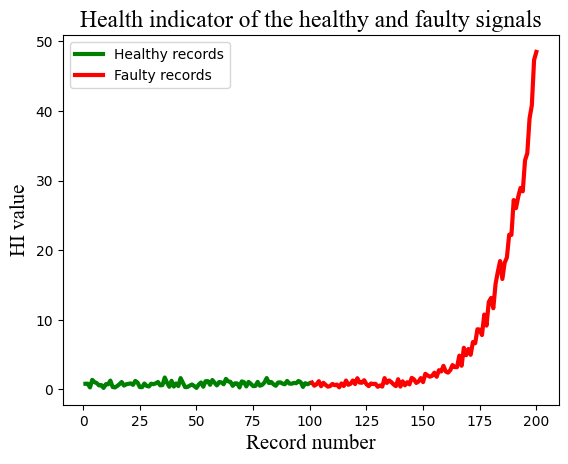

In [6]:
# Part for figures
axis_font_size = 10
title_font_size = 17
axis_name_font_size = 15
lgnd_font_size = 10

plt.figure()
plt.plot(range(1, num_healthy_sigs + 1), healthy_hi_vctr, linewidth=3, color='g')
plt.plot(range(num_healthy_sigs + 1, num_healthy_sigs + num_faulty_sigs + 1), hi_faulty_vctr, linewidth=3, color='r')
plt.xlabel('Record number', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.ylabel('HI value', fontname='Times New Roman', fontsize=axis_name_font_size)
plt.legend(['Healthy records', 'Faulty records'], loc='upper left', prop={'size': lgnd_font_size})
plt.title('Health indicator of the healthy and faulty signals', fontname='Times New Roman', fontsize=title_font_size)
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

plt.show()